In [65]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [66]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', google_api_key = os.getenv('GEMINI_KEY'))
embedding_function = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",  # Correct embedding model
    google_api_key=os.getenv('GEMINI_KEY')
)

In [67]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
docs = [WebBaseLoader(url).load() for url in urls]
doc_list =[item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=0)
docs_split = text_splitter.split_documents(doc_list)

vectordb = Chroma.from_documents(documents=docs_split, collection_name="rag-chroma", embedding=embedding_function)
retriever = vectordb.as_retriever()

#Creating a Rag Chain

In [68]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull('rlm/rag-prompt')

print(f'the Prompt -----{prompt}')

def formt_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt |llm|StrOutputParser()

/home/dev/Desktop/langchain/myenv/lib/python3.10/site-packages/langsmith/client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


the Prompt -----input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [69]:
question = "what is agent memory"
result = rag_chain.invoke({"context":docs,'question':question})
result

'Agent memory in LLMs refers to the mechanisms used to acquire, store, retain, and retrieve information. It includes short-term memory, which is similar to in-context learning, and long-term memory, which uses external vector stores for extended information recall. This memory helps agents retain and recall information over time, improving their ability to perform tasks.'

### Query Grader

In [70]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
class GradeDocuments(BaseModel):
    """Binary score for relevance check on the retrived documents."""

    binary_score:str=Field(description="Documents are relevant to the question, 'no' or 'yes'")

In [71]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [72]:
question = "Tell me about Agents"
docs = retriever.get_relevant_documents(question)
print(docs)
doc_txt = docs[0].page_content
print(doc_txt)
print(retrieval_grader.invoke({'question':question, "document":doc_txt}))

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

### Query re-writter

In [147]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question. only return one question",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [148]:
question_rewriter.invoke({'question':question})

'What are intelligent agents and how do they work?'

create the function

In [149]:
def retrive(state):
    """
    Retrieve Documents

    Args:
        state (dict): The current graph state

    Returns:
    
    """
    print('----Retrieve----')
    question = state['question']

    documents = retriever.get_relevant_documents(question)
    return {"documents":documents, "question":question}

In [150]:
state={'question':"what is agent"}
retrive(state)

----Retrieve----


{'documents': [Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineer

In [151]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")
    
    question = state["question"]
    
    documents = state["documents"]
   

    # Score each doc
    filtered_docs = []
    
    web_search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}





In [152]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    
    return {"documents": documents, "question": question, "generation": generation}

In [153]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    
    return {"documents": documents, "question": better_question}

### Web Crawling we gonna perform using Tavily

In [154]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [155]:
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    
    web_results = "\n".join([d["content"] for d in docs])
    
    web_results = Document(page_content=web_results)
    
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [156]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [157]:
from langgraph.graph import StateGraph, START,END


In [158]:
from typing import TypedDict,List

class State(TypedDict):
    """Represents the state of the graph.
    
    Attributes:
        question:question
        generation:llm generation
        web_search:wheather to add search
        documents:documents
    """
    question:str
    generation:str
    web_search:str
    documents:List[str]

In [159]:
workflow = StateGraph(State)
workflow.add_node('retrive', retrive)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)
workflow.add_node('transform_query', transform_query)
workflow.add_node('websearch_node', web_search)

In [160]:
workflow.add_edge(START, 'retrive')
workflow.add_edge('retrive', "grade_documents")
workflow.add_conditional_edges("grade_documents", decide_to_generate, {"transform_query":'transform_query', 'generate':'generate'})
workflow.add_edge('transform_query', 'websearch_node')
workflow.add_edge('websearch_node', 'generate')
workflow.add_edge('generate', END)


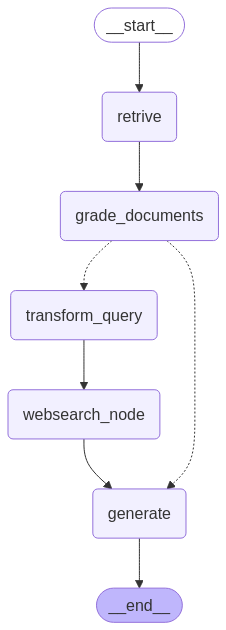

In [161]:
app= workflow.compile()
app

In [170]:
from pprint import pprint
inputs = {"question": "what is langraph "}

In [171]:
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}:")
    pprint(('\n---\n'))
pprint(value['generation'])

----Retrieve----
"Node 'retrive:"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
this is  the [Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n